# 期末類別型資料分析

C111156103, 潘奕濬


## 環境設定


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib_inline

plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Import data from UCI machine learning repository


In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
assert mushroom.data is not None
assert isinstance(mushroom.data.features, pd.DataFrame)
assert isinstance(mushroom.data.targets, pd.DataFrame)

X = mushroom.data.features
y = mushroom.data.targets

In [4]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.to_numpy().ravel())

## 切割資料集與訓練集

訓練級是用來回測的。


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## Pre-Processing


In [6]:
from typing import Literal, Self
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin


class DropNullColumns(BaseEstimator, TransformerMixin):
    transform_type: None | Literal["default", "pandas"]

    def __init__(self, columns: list[str] | None = None):
        self.columns = columns
        self.transform_type = None

    def fit(self, X: pd.DataFrame, _: pd.Series | None = None) -> Self:
        self.null_columns = X.columns[X.isnull().any()]
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame | np.ndarray:
        dropped_X = X.drop(columns=self.null_columns)

        if self.transform_type == "pandas":
            return dropped_X
        else:
            return dropped_X.to_numpy()

    def set_output(
        self, *, transform: None | Literal["default", "pandas"] = None
    ) -> BaseEstimator:
        self.transform_type = transform
        return self


preprocessor = Pipeline(
    [
        # 缺失值處理
        ("drop_cols", DropNullColumns()),
        (
            "encode",
            ColumnTransformer(
                [
                    # label encoding for binary data
                    (
                        "binary",
                        OrdinalEncoder(),
                        [
                            "bruises",
                            "gill-attachment",
                            "gill-spacing",
                            "gill-size",
                            "stalk-shape",
                        ],
                    ),
                    # one-hot encoding for non-binary data
                    (
                        "onehot",
                        OneHotEncoder(dtype="int64", sparse_output=False),
                        [
                            "cap-shape",
                            "cap-surface",
                            "cap-color",
                            "odor",
                            "gill-color",
                            "stalk-surface-above-ring",
                            "stalk-surface-below-ring",
                            "stalk-color-above-ring",
                            "stalk-color-below-ring",
                            "veil-color",
                            "ring-number",
                            "ring-type",
                            "spore-print-color",
                            "population",
                            "habitat",
                        ],
                    ),
                ],
                n_jobs=-1,
            ),
        ),
        (
            "lda",
            LinearDiscriminantAnalysis(n_components=1),
        ),
        ("standardize", StandardScaler()),
    ],
)

preprocessor.set_output(transform="pandas")
preprocessor

Pipeline(steps=[('drop_cols', DropNullColumns()),
                ('encode',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('binary', OrdinalEncoder(),
                                                  ['bruises', 'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'stalk-shape']),
                                                 ('onehot',
                                                  OneHotEncoder(dtype='int64',
                                                                sparse_output=False),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'odor',
                                                   'gill-color',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',
                                                   'veil-color', 'ring-number',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'population',
                                                   'habitat'])])),
                ('lda', LinearDiscriminantAnalysis(n_components=1)),
                ('standardize', StandardScaler())])

In [7]:
X_train_pp = preprocessor.fit_transform(X_train, y_train)
X_test_pp = preprocessor.transform(X_test)

## 建立模型

實作完整的八種機器學習算法：LR、DT、RF、SVM、KNN、XGB、Bagging、AdaBoost

### 算法說明：

1. **LR (Logistic Regression)**: 邏輯回歸，線性分類器
2. **DT (Decision Tree)**: 決策樹，基於樹狀結構的分類器
3. **RF (Random Forest)**: 隨機森林，多個決策樹的集成學習
4. **SVM (Support Vector Machine)**: 支持向量機，基於核函數的分類器
5. **KNN (K-Nearest Neighbors)**: K 最近鄰，基於距離的分類器
6. **XGB (XGBoost)**: 極端梯度提升，基於梯度提升的集成學習
7. **Bagging**: 裝袋法，多個弱學習器的並行集成
8. **AdaBoost**: 自適應提升，多個弱學習器的串行集成

### 參數設定：

- DT 使用之前 GridSearchCV 找出的最佳參數：`{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}`
- RF 使用之前 GridSearchCV 找出的最佳參數：`{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}`
- SVM 使用 RBF 核函數，開啟概率預測
- KNN 使用 k=5，uniform 權重
- XGBoost 使用默認參數，添加 eval_metric='logloss'
- Bagging 和 AdaBoost 都以決策樹為基學習器

### KFold 設定：

- 使用 K-Fold 交叉驗證來獲得更穩健的模型性能評估，減少因為特定訓練/測試集分割造成的偏差。
- 採 5 折

### 環境要求：

- macOS 需要安裝 `libomp` 才能執行 XGBoost：`brew install libomp`


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # brew install libomp
from sklearn.model_selection import cross_val_score

assert X_train_pp is not None
assert isinstance(X_train_pp, pd.DataFrame)


# 最佳參數設定
dt_best_params = {
    "criterion": "gini",
    "max_depth": None,
    "min_samples_leaf": 1,
    "min_samples_split": 10,
}
rf_best_params = {
    "max_depth": None,
    "min_samples_leaf": 1,
    "min_samples_split": 5,
    "n_estimators": 100,
}

# 建立分類器實例
lr_classifier = LogisticRegression(random_state=42, max_iter=1000, solver="liblinear")
dt_classifier = DecisionTreeClassifier(random_state=42, **dt_best_params)
rf_classifier = RandomForestClassifier(random_state=42, **rf_best_params)
svm_classifier = SVC(
    random_state=42, probability=True, kernel="rbf", C=1.0, gamma="scale"
)
knn_classifier = KNeighborsClassifier(
    n_neighbors=5, weights="uniform", algorithm="auto"
)
xgb_classifier = XGBClassifier(random_state=42, eval_metric="logloss")
bagging_classifier = BaggingClassifier(
    estimator=dt_classifier, random_state=42, n_estimators=10
)
adaboost_classifier = AdaBoostClassifier(
    estimator=dt_classifier, random_state=42, n_estimators=50, learning_rate=1.0
)

# 所有算法列表
algorithms = [
    lr_classifier,
    dt_classifier,
    rf_classifier,
    svm_classifier,
    knn_classifier,
    xgb_classifier,
    bagging_classifier,
    adaboost_classifier,
]

classifiers: dict[str, Pipeline] = {}

cv = 10

for algorithm in algorithms:
    # 每個 model 結尾都有 Classifier，這個我們需要移除掉
    model_name = algorithm.__class__.__name__
    if model_name.endswith("Classifier"):
        model_name = model_name[: -len("Classifier")]

    # 特殊處理一些模型名稱
    if model_name == "LogisticRegression":
        model_name = "LR"
    elif model_name == "SVC":
        model_name = "SVM"
    elif model_name == "KNeighbors":
        model_name = "KNN"
    elif model_name == "XGB":
        model_name = "XGBoost"

    algorithm.fit(X_train_pp, y_train)

    scores = cross_val_score(
        algorithm,
        X_train_pp.to_numpy(),
        y_train,
        cv=cv,
        scoring="accuracy",
        error_score="raise",
    )
    print(
        f"{model_name} 在 train set 的 {cv=} 準確率：{scores.mean():.4f} ± {scores.std():.4f}"
    )
    classifiers[model_name] = algorithm


LR 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
DecisionTree 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
RandomForest 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
SVM 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
KNN 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
XGBoost 在 train set 的 cv=10 準確率：0.9985 ± 0.0024
Bagging 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
AdaBoost 在 train set 的 cv=10 準確率：0.9998 ± 0.0005


## 針對每個模型做混淆矩陣


In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrixes = {
    name: confusion_matrix(y_test, algorithm.predict(X_test_pp))
    for name, algorithm in classifiers.items()
}

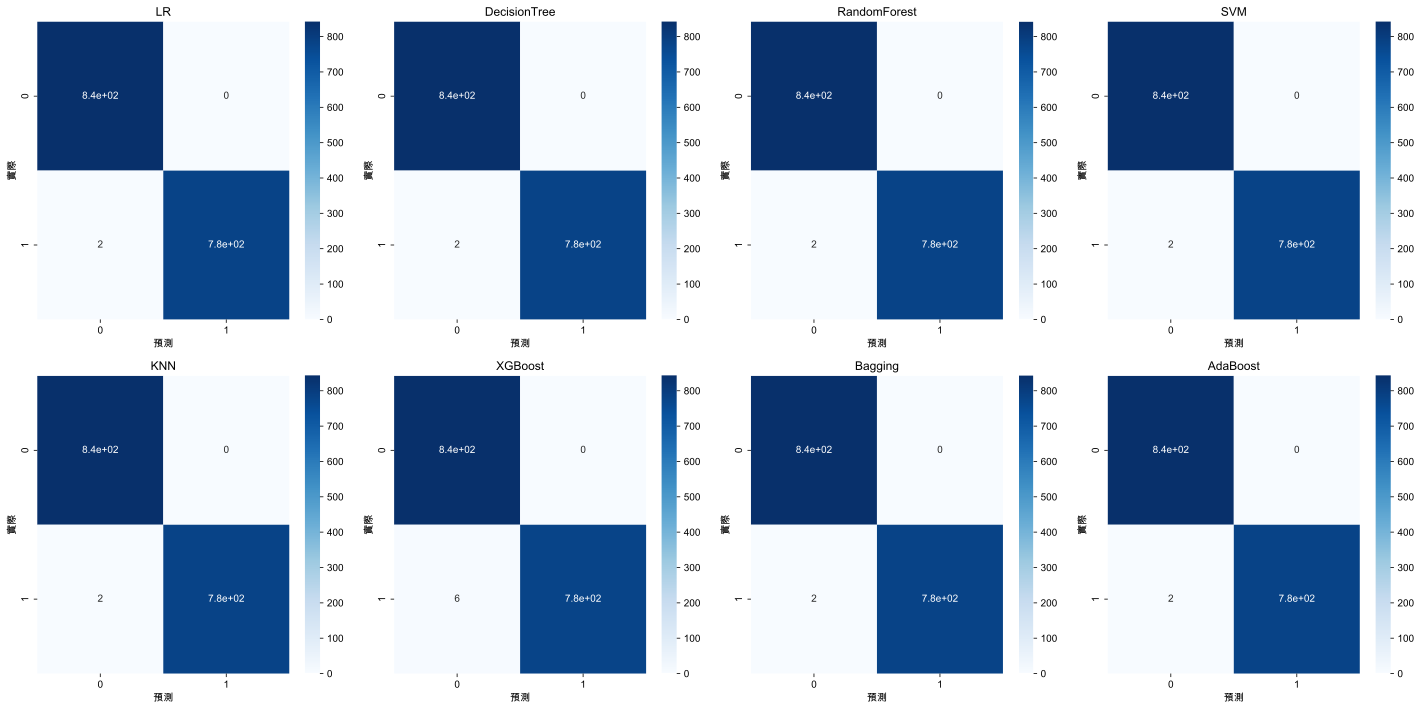

In [10]:
import seaborn as sns

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for idx, (name, matrix) in enumerate(confusion_matrixes.items()):
    row = idx // 4
    col = idx % 4
    sns.heatmap(matrix, annot=True, cmap="Blues", ax=ax[row, col])
    ax[row, col].set_title(name)
    ax[row, col].set_xlabel("預測")
    ax[row, col].set_ylabel("實際")

fig.tight_layout()
plt.show()


## 測出 Accuracy、Precision、Recall 和 F1


In [11]:
from sklearn.metrics import (
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
)
from imblearn.metrics import specificity_score

scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "Specificity": make_scorer(specificity_score),
    "F1": make_scorer(f1_score),
    "AUC": make_scorer(roc_auc_score),
}

scores = [
    {
        "Model": name,
        **{
            scorer_name: scorer(classifier, X_test_pp, y_test)
            for scorer_name, scorer in scorers.items()
        },
    }
    for name, classifier in classifiers.items()
]

results_df = pd.DataFrame(scores)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
results_df.set_index("Model", inplace=True)

results_df

,Accuracy,Precision,Recall,Specificity,F1,AUC
Model,,,,,,
LR,0.998769,1.0,0.997446,1.0,0.998721,0.998723
DecisionTree,0.998769,1.0,0.997446,1.0,0.998721,0.998723
RandomForest,0.998769,1.0,0.997446,1.0,0.998721,0.998723
SVM,0.998769,1.0,0.997446,1.0,0.998721,0.998723
KNN,0.998769,1.0,0.997446,1.0,0.998721,0.998723
Bagging,0.998769,1.0,0.997446,1.0,0.998721,0.998723
AdaBoost,0.998769,1.0,0.997446,1.0,0.998721,0.998723
XGBoost,0.996308,1.0,0.992337,1.0,0.996154,0.996169


## ROC 曲線與 AUC


In [12]:
import matplotlib.pyplot as plt
import matplotlib_inline

plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

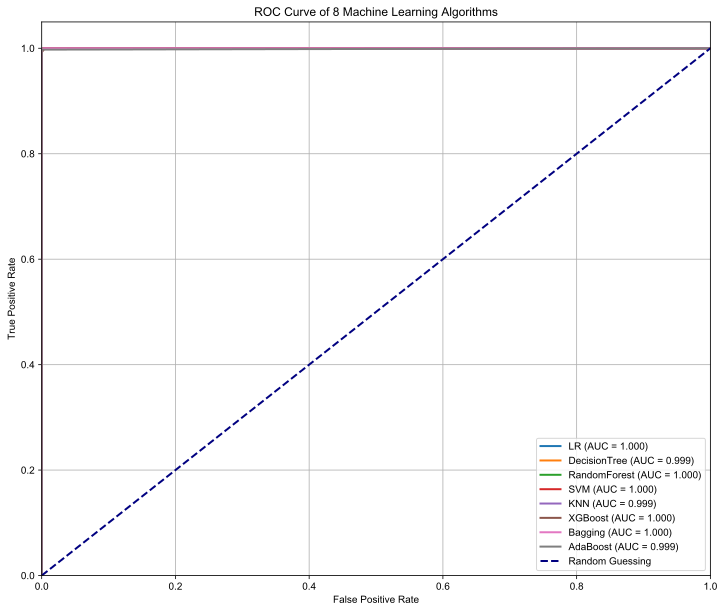

In [13]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 10))

for name, classifier in classifiers.items():
    # Get probability estimates for the positive class
    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test_pp)[:, 1]
    else:
        # For classifiers without predict_proba (e.g., SVM with probability=False)
        y_score = classifier.decision_function(X_test_pp)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of 8 Machine Learning Algorithms")
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0))
plt.grid(True)
plt.show()